In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys, warnings
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format

2022-09-22 11:48:04.263692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-09-22 11:48:04.263731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 0. Functions

### 0.1. Encoding Functions

In [2]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        feat_ = feat.replace("_Peak","")
        feat_ = feat_.replace("_Trough","")
        
        if data_types[feat_] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat_], [mean, std]])
            
        elif data_types[feat_] == 'Categorical':
            #X_data_norm_2[feat] = X_data[feat].copy()
            #encoder.append([feat, data_types[feat_], ""])
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat_], df])
            
        elif data_types[feat_] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat_], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:        
        feat_encode = norm_encoder[norm_encoder['feature'] == feat].iloc[0]
        if feat_encode['type'] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = feat_encode['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif feat_encode['type'] == 'Categorical':
            #X_data_norm_2[feat] = val_data[feat].copy()
            df = feat_encode['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif feat_encode['type'] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
############################################################

### 0.2. Split Data Function

In [3]:

def train_valid_sets(X_train_set, X_valid_set):
    #######################################
    ### SPLIT DATA
    #######################################
    train_set = X_train_set
    valid_set = X_valid_set

    print('total admissions 16 18', len(X_train_set))
    print('total admissions 19 20', len(X_valid_set))
    print('X_train', len(train_set))
    print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
          'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
    print('X_valid', len(valid_set))
    print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
          'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))
    return train_set, valid_set

### 0.3. Encoding Data Function

In [4]:
def encoding_data(train_set, valid_set, feat_list, data_types):
    ############################################################
    train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
    valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)
    print("==========================================================================================================")
    print('----------------------------------TRAIN SET---------------------------------------------------------------')
    print("==========================================================================================================")
    display(train_set.head(4))
    display(train_set_norm.head(4))
    print("==========================================================================================================")
    print('----------------------------------VALIDATION SET----------------------------------------------------------')
    print("==========================================================================================================")
    display(valid_set.head(4))
    display(valid_set_norm.head(4))
    display(encoder)
    return train_set_norm, valid_set_norm, encoder

# 1. Load Data

In [5]:
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18_ews_1d.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20_ews_1d.pickle','rb'))


print("=================================FIRST RECORDED SAMPLE ADMISSION=================================")
print("-------------------------------------- 2016 - 2018 ----------------------------------------------")
display(X_data_16_18[0].head(3))
print("")
print("-------------------------------------- 2019 - 2020 ----------------------------------------------")
display(X_data_19_20[0].head(3))

print("Elapsed time:", time.time()-t)

=================================FIRST RECORDED SAMPLE ADMISSION=================================
-------------------------------------- 2016 - 2018 ----------------------------------------------


,admission_id,rr,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,Mortality
0,30454500,16.000,143.000,36.400,81.000,49.000,90.000,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
1,30454500,15.000,115.667,36.500,88.667,62.333,92.667,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
2,30454500,14.000,88.333,36.600,96.333,75.667,95.333,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000



-------------------------------------- 2019 - 2020 ----------------------------------------------


,admission_id,rr,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,Mortality
0,58578756,20.000,110.000,38.400,147.000,92.000,97.000,0.000,0.000,95.000,...,0.080,45.000,137.000,12.000,-1.000,0.000,59.000,6.000,1.000,0.000
1,58578756,19.619,108.190,38.343,145.762,90.667,96.905,0.000,0.000,95.000,...,0.080,45.000,137.000,12.000,-1.000,0.000,59.000,6.000,1.000,0.000
2,58578756,19.238,106.381,38.286,144.524,89.333,96.810,0.000,0.000,94.750,...,0.079,44.958,137.073,11.969,-1.000,0.000,59.000,6.000,1.000,0.000


Elapsed time: 0.3165268898010254


In [6]:
len(X_data_16_18[0][X_data_16_18[0]['Mortality']==1]['admission_id'].unique())

1457

In [7]:
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'CREA', 'UREA', 'K', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB', 'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb']
Number of features: 32


In [8]:
# Loading the CSV with types
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# Processing Data

In [9]:
# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()
### SPLIT DATA #######################################
train_set = X_data_16_18[0].copy()
valid_set = X_data_19_20[0].copy()

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = len(train_set[train_set['admission_id']==train_set['admission_id'].tolist()[0]])
X_train    = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid    = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
df         = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_train    = np.array(X_data_16_18[1].copy())

df         = valid_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_valid    = np.array(X_data_19_20[1].copy())
print("Elapsed time processing data:", time.time()-t)
# ============================================================================

Elapsed time processing data: 0.8851892948150635


In [10]:
X_data_16_18[0]

,admission_id,rr,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,Mortality
0,30454500,16.000,143.000,36.400,81.000,49.000,90.000,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
1,30454500,15.000,115.667,36.500,88.667,62.333,92.667,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
2,30454500,14.000,88.333,36.600,96.333,75.667,95.333,1.000,1.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
3,30454500,13.000,61.000,36.700,104.000,89.000,98.000,1.000,0.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
4,30454500,13.400,65.400,36.720,105.000,89.000,97.600,1.000,0.000,76.000,...,0.020,30.000,120.500,8.000,1.000,0.000,72.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102507,52573088,18.000,69.000,36.756,105.667,50.222,96.444,1.000,1.000,56.524,...,0.038,38.000,93.000,12.000,1.000,0.000,80.000,6.000,1.000,0.000
1102508,52573088,18.000,71.000,36.778,106.333,51.111,96.222,1.000,1.000,56.392,...,0.038,38.000,93.000,12.000,1.000,0.000,80.000,6.000,1.000,0.000
1102509,52573088,18.000,73.000,36.800,107.000,52.000,96.000,1.000,1.000,56.260,...,0.038,38.000,93.000,12.000,1.000,0.000,80.000,6.000,1.000,0.000
1102510,52573088,18.000,72.857,36.829,108.286,52.000,96.000,1.000,1.000,56.128,...,0.038,38.000,93.000,12.000,1.000,0.000,80.000,6.000,1.000,0.000


# Modelling GRU

In [11]:
y_train_1 = to_categorical(y_train, num_classes = 20)
y_valid_1 = to_categorical(y_valid, num_classes = 20)

print("Shape of X_train",X_train.shape)
print("Shape of y_train",y_train_1.shape)
y_train_1

Shape of X_train (7657, 48, 32)
Shape of y_train (7657, 20)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
def hamming_score(y_true, y_pred):#, normalize=True, sample_weight=None)
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set(np.where(y_true[i])[0] )
        set_pred = set(np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

from tensorflow.keras.metrics import CategoricalAccuracy
t = time.time()

model = Sequential()

model.add(layers.GRU(10, activation='relu', input_shape=(48, 32)))  
model.add(layers.Dense(20, activation='softmax'))

#score_HamSc = make_scorer(hamming_score)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam')

history = model.fit(X_train, y_train_1, validation_split=0.3, verbose=0, epochs=50, batch_size =400)
print("elapsed, ", time.time()-t)

2022-09-22 11:48:10.771429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-09-22 11:48:10.777497: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 11:48:10.777714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre11): /proc/driver/nvidia/version does not exist
2022-09-22 11:48:10.779257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

elapsed,  16.6452054977417


In [13]:
history.history

{'loss': [3.0501351356506348,
  2.893314838409424,
  2.752030611038208,
  2.616791248321533,
  2.4786794185638428,
  2.3336448669433594,
  2.182190179824829,
  2.0352632999420166,
  1.9183024168014526,
  1.8479171991348267,
  1.8024258613586426,
  1.7726339101791382,
  1.7487518787384033,
  1.7311981916427612,
  1.7161401510238647,
  1.7032166719436646,
  1.6925547122955322,
  1.6825165748596191,
  1.6749284267425537,
  1.6667585372924805,
  1.6604015827178955,
  1.654420018196106,
  1.6495319604873657,
  1.644357442855835,
  1.6395611763000488,
  1.6347867250442505,
  1.6304768323898315,
  1.6267842054367065,
  1.6229435205459595,
  1.6192750930786133,
  1.6151906251907349,
  1.6108800172805786,
  1.608119249343872,
  1.604299545288086,
  1.6009753942489624,
  1.5988662242889404,
  1.5951639413833618,
  1.5907297134399414,
  1.586970329284668,
  1.5839837789535522,
  1.5834344625473022,
  1.5778467655181885,
  1.5750327110290527,
  1.5718363523483276,
  1.5678764581680298,
  1.5656102

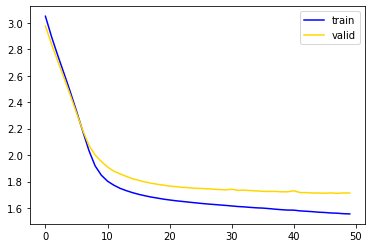

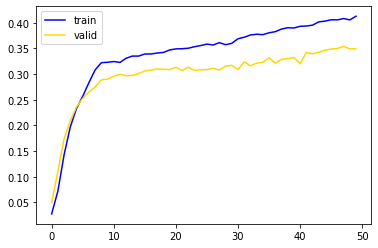

In [14]:
import matplotlib.pyplot as plt
x = np.asarray(range(50))
plt.plot(x, history.history['loss'], color ='b', label ='train')
plt.plot(x, history.history['val_loss'], color='gold', label='valid')
plt.legend()
plt.show()

plt.plot(x, history.history['accuracy'], color='b', label = 'train')
plt.plot(x, history.history['val_accuracy'],color='gold', label='valid')
plt.legend()
plt.show()

In [15]:
print("Shape of X_valid",X_valid.shape)
print("Shape of y_valid",y_valid_1.shape)
y_test_proba    = model.predict(X_valid)

Shape of X_valid (6531, 48, 32)
Shape of y_valid (6531, 20)


cummulative of one sample 1.0000001


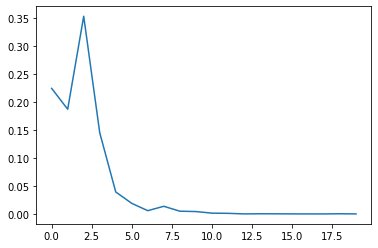

In [16]:
test = y_test_proba[1000]
print('cummulative of one sample', test.sum() )
plt.plot(range(len(test)), test)
plt.show()

In [17]:
idx    = np.argmax(y_test_proba, axis=-1)
y_pred = np.zeros( y_test_proba.shape )
y_pred[np.arange(y_pred.shape[0]), idx] = 1
y_pred

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [18]:
hamming_score(y_valid, y_pred)

0.06170571122339611

In [19]:
y_list_true = [idx for x in y_valid_1 for idx, i in enumerate(x) if i == 1]
y_list_pred = [idx for x in y_pred for idx, i in enumerate(x) if i == 1]

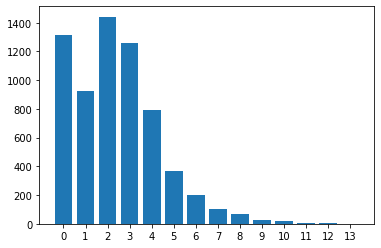

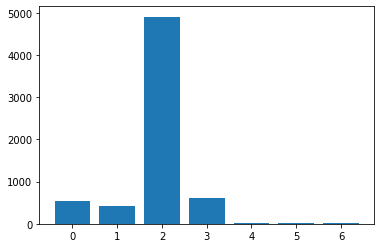

In [20]:
labels, counts = np.unique(y_list_true , return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

labels, counts = np.unique(y_list_pred , return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

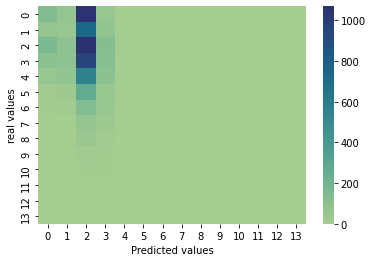

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_list_true, y_list_pred)

sns.heatmap(cnf_matrix, cmap ='crest')
plt.ylabel('real values')
plt.xlabel('Predicted values')
plt.show()

____________________

________________________

________________________________

# Optimise LSTM with Grid

In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from bayes_opt import BayesianOptimization

In [23]:
# ##############
# 3. BAYESIAN OPTIMIZER TO FINE TUNE THE NEURAL NETWORK
# ============================================================================
def nn_cl_bo2(optimizer, learning_rate, batch_size, epochs, activation1):
    
    optimizerD = {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', layers.LeakyReLU]
    
    activation1 = activationL[round(activation1)]
    optimizer  = list(optimizerD.keys())[round(optimizer)]
    batch_size = round(batch_size)
    epochs     = round(epochs)
    
    score_acc = make_scorer(accuracy_score)
    
    def nn_cl_fun():      
        model = Sequential()

        model.add(layers.GRU(25, activation=activation1, input_shape=(48, 32),return_sequences = True))
        model.add(layers.GRU(15, activation=activation1))
        model.add(layers.Dense(20, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
#        history = model.fit(X_train, y_train_1, validation_split=0.3, verbose=0, epochs=50, batch_size =400)
    
    es    = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn    = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    #kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train_1, fit_params={'callbacks':[es]}).mean()
    return score

In [24]:
t = time.time()
optimizer     = 0
learning_rate = 0.1
batch_size    = 250
epochs        = 20
activation1   = 0
indv = nn_cl_bo2(optimizer, learning_rate, batch_size, epochs, activation1)
print("elapsed Fine tuning the NN", time.time()-t)
indv

elapsed Fine tuning the NN 93.74369287490845


0.38918206095695496

In [25]:
t = time.time()
params_nn2 ={'activation1':(0, 7), 'optimizer':(0,7), 'learning_rate':(0.01, 0.05),
             'batch_size':(100, 1000), 'epochs':(20, 100)}
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=5, n_iter=4)
print("elapsed Fine tuning the NN", time.time()-t)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... | optimizer |
-------------------------------------------------------------------------------------
|  1        |  0.3816   |  4.285    |  252.2    |  54.88    |  0.04077  |  2.067    |
|  2        |  0.3991   |  1.044    |  120.2    |  53.62    |  0.01955  |  2.364    |
|  3        |  0.2931   |  6.935    |  314.0    |  26.5     |  0.03678  |  4.349    |
|  4        |  0.3803   |  1.92     |  519.6    |  29.47    |  0.01296  |  6.305    |
|  5        |  0.2505   |  5.558    |  856.5    |  85.22    |  0.04964  |  4.041    |
|  6        |  0.3928   |  0.939    |  119.8    |  54.51    |  0.0336   |  1.753    |
|  7        |  0.3794   |  3.593    |  129.4    |  37.43    |  0.04683  |  6.096    |
|  8        |  0.2931   |  6.994    |  110.3    |  39.82    |  0.04682  |  6.037    |
|  9        |  0.3616   |  0.0      |  131.6    |  52.07    |  0.01     |  5.686    |
elapsed Fine tuning the NN 2215.2626123428345


In [26]:
y_train_1

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)